In [11]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import function
from sklearn.preprocessing import MinMaxScaler

In [12]:
df_origin = pd.read_excel('../VisitorEntrancesV3.xlsx')

In [13]:
df = df_origin[df_origin.Site_Name=='Caesarea']
df = function.remove_unique_one(df)
df = df.drop(df.filter(regex='Season').columns, axis=1)
df = df.drop(df.filter(regex='Exceeded').columns, axis=1)
df = df.drop(df.filter(regex='isHeatwave').columns, axis=1)
df = df.replace({True:1,False:0})

In [14]:
dfWithoutLastYearVisits = df.dropna().drop('last_year_visitors',axis=1)
dfLastYearVisits = df.dropna()

In [15]:
print(dfLastYearVisits.shape)
print(dfWithoutLastYearVisits.shape)

(433, 8)
(433, 7)


In [16]:
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from IPython.display import clear_output
from keras.regularizers import l2

In [17]:
dfWithoutLastYearVisits.sort_values('Date')
X = dfWithoutLastYearVisits.drop(['Israelis_Count'],axis=1)
y = dfWithoutLastYearVisits[['Date','Israelis_Count']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train.drop('Date',axis=1))
X_test_scaled = X_test_scaler.fit_transform(X_test.drop('Date',axis=1))
 
X_train_scaled


X_train_date = X_train.Date
y_train_date = y_train.Date
X_test_date = X_test.Date
y_test_date = y_test.Date

y_train.drop('Date',axis=1,inplace=True)
y_test.drop('Date',axis=1,inplace=True)

In [27]:
# create NN model
model = Sequential()
model.add(Dense(X_train_scaled.shape[1], input_dim=X_train_scaled.shape[1],activation='relu',activity_regularizer=l2(0.01)))
model.add(Dense(128,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(16,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
 

In [28]:
# # Compiling the model
# model.compile(metrics=['mae','accuracy'], optimizer='adam', loss = 'mean_squared_error')
# es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1 )
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=0 )
# mcp = ModelCheckpoint(filepath='weightsCeasareaWithoutLastYearVisits.h5', monitor='val_loss', verbose=1 , save_best_only=True, save_weights_only=True)

# tb = TensorBoard('logs')

# history = model.fit(X_train_scaled, y_train, shuffle=True, epochs=10000,callbacks=[es, rlr, mcp, tb],validation_split=0.2,batch_size=1)
# clear_output(True)


In [29]:
model.load_weights('weightsCeasareaWithoutLastYearVisits.h5')

11/11 [==============================] - 0s 2ms/step

mae 440.1865774165688
rmse 630.4278013976079
std 780.967600162725


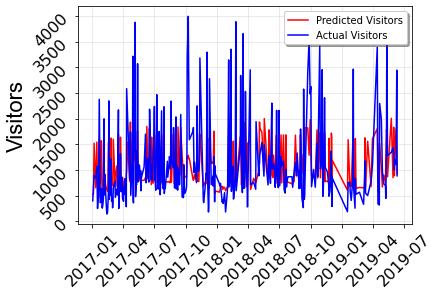

,Prediction,Actual
Date,,
2017-01-02,524.729431,401
2017-01-04,538.539490,663
2017-01-06,1522.794556,898
2017-01-11,654.052490,845
2017-01-14,1545.096558,1075
2017-01-16,700.927368,253
2017-01-17,712.298462,382
2017-01-19,670.189636,480
2017-01-21,1605.535278,2377


In [30]:
prediction = model.predict(X_train_scaled)
prediction = prediction.reshape(len(X_train_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_train.values.T[0],
        },
    index=y_train_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

3/3 [==============================] - 0s 3ms/step

mae 479.4020554115032
rmse 650.7218599472664
std 793.901068849987


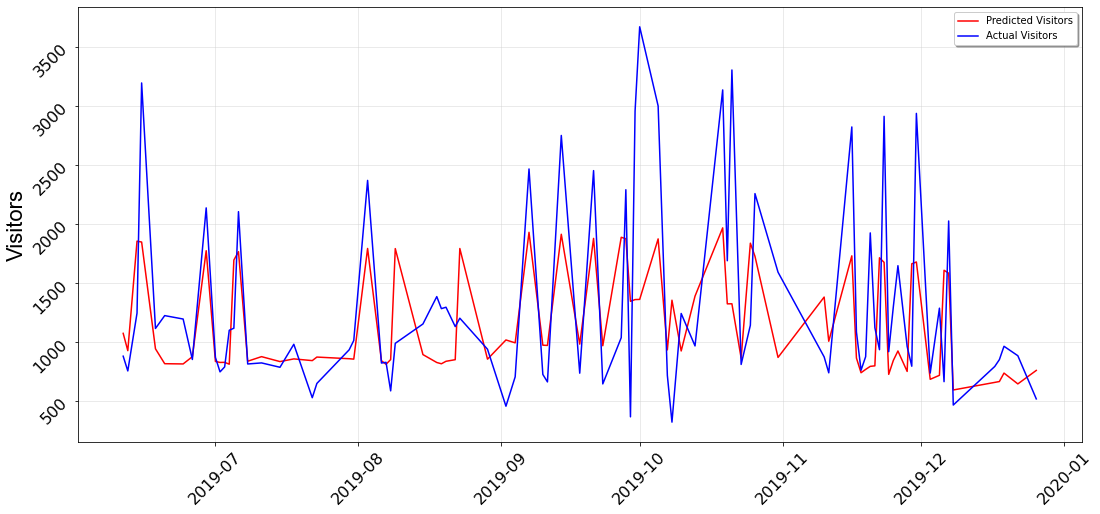

,Prediction,Actual
Date,,
2019-06-11,1074.607666,881
2019-06-12,927.879211,756
2019-06-14,1856.089722,1246
2019-06-15,1848.463501,3197
2019-06-18,943.445435,1116
2019-06-20,817.314941,1225
2019-06-24,815.286194,1196
2019-06-26,876.782959,853
2019-06-29,1774.994141,2138


In [31]:
prediction = model.predict(X_test_scaled)
prediction = prediction.reshape(len(X_test_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_test.values.T[0],
        },
    index=y_test_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

In [32]:
from lime_stability.stability import LimeTabularExplainerOvr

class_names=['Israelis_Count']

categorical_features = np.argwhere(
    np.array([len(set(X_train_scaled[:,x]))
    for x in range(X_train_scaled.shape[1])]) <= 2).flatten()

print(X_train_scaled.shape)
print(categorical_features.shape)
print(X_train_scaled.shape)

explainer = LimeTabularExplainerOvr(np.array(X_train_scaled),
 feature_names=X_train.drop('Date',axis=1).columns,
 class_names=class_names, 
 categorical_features=categorical_features, 
 verbose=True,
 mode='regression'
 )

i = np.random.randint(len(X_test_scaled))
print('index ', i, ':: Actual values = ', y_test.Israelis_Count.values[i])
print('index ', i, ':: Prediction values = ', prediction.tolist()[i])
exp = explainer.explain_instance((X_test_scaled[i]),model.predict,num_features=100)
exp.show_in_notebook(show_table=True)
function.outputLimeAsDf(exp)


(346, 5)
(3,)
(346, 5)
index  65 :: Actual values =  762
index  65 :: Prediction values =  740.6812744140625
157/157 [==============================] - 0s 2ms/step
Intercept 1883.992039724831
Prediction_local [761.40765311]
Right: 740.6813


,0
is weekend,896.677003
IsHoliday,304.312313
IsVacation,-147.050823
Temperature,-54.665426
pm10,-13.980467


In [33]:
function.getLimeAvg(X_test_scaled=X_test_scaled,X_train_scaled=X_train_scaled,X_train=X_train,model=model)

(346, 5)
(3,)
(346, 5)
157/157 [==============================] - 0s 2ms/step
Intercept 1833.168596671605
Prediction_local [930.52204029]
Right: 1074.6077
157/157 [==============================] - 0s 2ms/step
Intercept 1835.6451441230465
Prediction_local [931.90138824]
Right: 1074.6077
157/157 [==============================] - 0s 2ms/step
Intercept 1827.0385594942263
Prediction_local [935.63555831]
Right: 1074.6077
157/157 [==============================] - 0s 2ms/step
Intercept 1836.9470696860606
Prediction_local [933.40931477]
Right: 1074.6077
157/157 [==============================] - 0s 2ms/step
Intercept 1846.329921230441
Prediction_local [932.74265049]
Right: 1074.6077
157/157 [==============================] - 0s 2ms/step
Intercept 1849.5376337453097
Prediction_local [932.52831155]
Right: 1074.6077
157/157 [==============================] - 0s 2ms/step
Intercept 1849.69223436943
Prediction_local [934.54177296]
Right: 1074.6077
157/157 [==============================] - 0s 2ms/

,0
IsVacation,-145.967054
Temperature,99.650698
is weekend,904.038983
IsHoliday,303.957556
pm10,-3.108861
